In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point

In [2]:
def plot_points(df: pd.DataFrame):
    """
    Plot points on a map within specified latitude and longitude bounds.

    Args:
        min_lat (float): The minimum latitude of the map.
        max_lat (float): The maximum latitude of the map.
        min_lon (float): The minimum longitude of the map.
        max_lon (float): The maximum longitude of the map.
        df (pd.DataFrame): DataFrame containing 'lat', 'lon', and 'target' columns.

    Returns:
        fig, ax: Figure and axes objects.
    """
    min_lat = df['lat'].min() -0.5
    max_lat = df['lat'].max() +0.5
    min_lon = df['lon'].min() -0.5
    max_lon = df['lon'].max() +0.5
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 12))

    df_1 = df[df['target'] == 1]
    df_2 = df[df['target'] == 0]
    
    # Plot points
    ax.scatter(df_1['lon'], df_1['lat'], c='r', alpha=0.3, s=1)
    ax.scatter(df_2['lon'], df_2['lat'], c='b', alpha=0.3, s=1)
    
    # Add basemap
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron, alpha=1)
    
    # Set x and y axis limits
    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)

    # Set x and y axis labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Set plot title
    ax.set_title('Points on Map')

    # Show grid
    ax.grid(True, alpha=0.3)

    # Return figure and axes objects
    return fig, ax

def geoframe_to_pandas(geo_dataframe: gpd.GeoDataFrame) -> pd.DataFrame:
    """
    Convert a GeoDataFrame to a Pandas DataFrame with 'lat' and 'lon' columns.

    Args:
        geo_dataframe (gpd.GeoDataFrame): GeoDataFrame with 'geometry' column containing Point geometries.

    Returns:
        pd.DataFrame: DataFrame with 'lat' and 'lon' columns.
    """
    # Extract latitudes and longitudes from the geometry column
    geometry = geo_dataframe['geometry']
    lats = [point.y for point in geometry]
    lons = [point.x for point in geometry]

    # Create a new DataFrame with latitudes and longitudes
    pandas_dataframe = pd.DataFrame({'lat': lats, 'lon': lons})

    # Add other columns from the GeoDataFrame if needed
    pandas_dataframe['target'] = geo_dataframe['target']  # Example: Adding 'target' column

    return pandas_dataframe

def remove_points_within_radius(geoframe, R) -> pd.DataFrame:
    # Create a copy of the input GeoDataFrame
    filtered_geoframe = geoframe.copy()
    
    # Iterate through each point with flag 1
    for idx, row in geoframe[geoframe['target'] == 1].iterrows():
        # Extract the coordinates of the point with flag 1
        point = row['geometry']
        
        # Create a buffer around the point with flag 1
        buffer = point.buffer(R)
        
        # Find points with flag 0 within the buffer and remove them
        points_within_buffer = filtered_geoframe[(filtered_geoframe['target'] == 0) & (filtered_geoframe['geometry'].within(buffer))]
        filtered_geoframe = filtered_geoframe.drop(points_within_buffer.index)
        
    return geoframe_to_pandas(filtered_geoframe)

def pandas_to_geoframe(dataframe: pd.DataFrame) -> gpd.GeoDataFrame:
        data = dataframe.copy()
        data['geometry'] = list(zip(data.lon, data.lat))
        data = data[['target','geometry']].copy()
        data['geometry'] = data["geometry"].apply(Point)
        geo_dataframe = gpd.GeoDataFrame(data)

        # Create the geodataframe
        output_dataframe = gpd.GeoDataFrame(
            gpd.GeoDataFrame(data),
            crs = {'init': 'EPSG:4326'},
            geometry = geo_dataframe['geometry']
        ).to_crs('EPSG:4326').reset_index(drop=True)
        return output_dataframe
    
def remove_no_data_values(raster_data: pd.DataFrame, raster_info: pd.DataFrame):
    for _, row in raster_info.iterrows():
        info_dict = row.to_dict()
        indexes = raster_data[raster_data[info_dict['name']] == info_dict['no_data']].index
        raster_data = raster_data.drop(indexes)
    return raster_data

In [3]:
raster_files = pd.read_parquet("C:/Users/kenji/dev/sdm_bio_vinaceous-breasted-amazon/data/features.parquet")
info = pd.read_parquet("C:/Users/kenji/dev/sdm_bio_vinaceous-breasted-amazon/data/raster_info.parquet")

raster_files_new = remove_no_data_values(raster_files, info)
raster_files_new = raster_files_new[['target','lat','lon']]

raster_files_new_geo = pandas_to_geoframe(raster_files_new)
df = remove_points_within_radius(raster_files_new_geo, R=0.05)

c:\Users\kenji\dev\sdm_bio_vinaceous-breasted-amazon\web-scraping-venv\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


(<Figure size 1000x1200 with 1 Axes>,
 <Axes: title={'center': 'Points on Map'}, xlabel='Longitude', ylabel='Latitude'>)

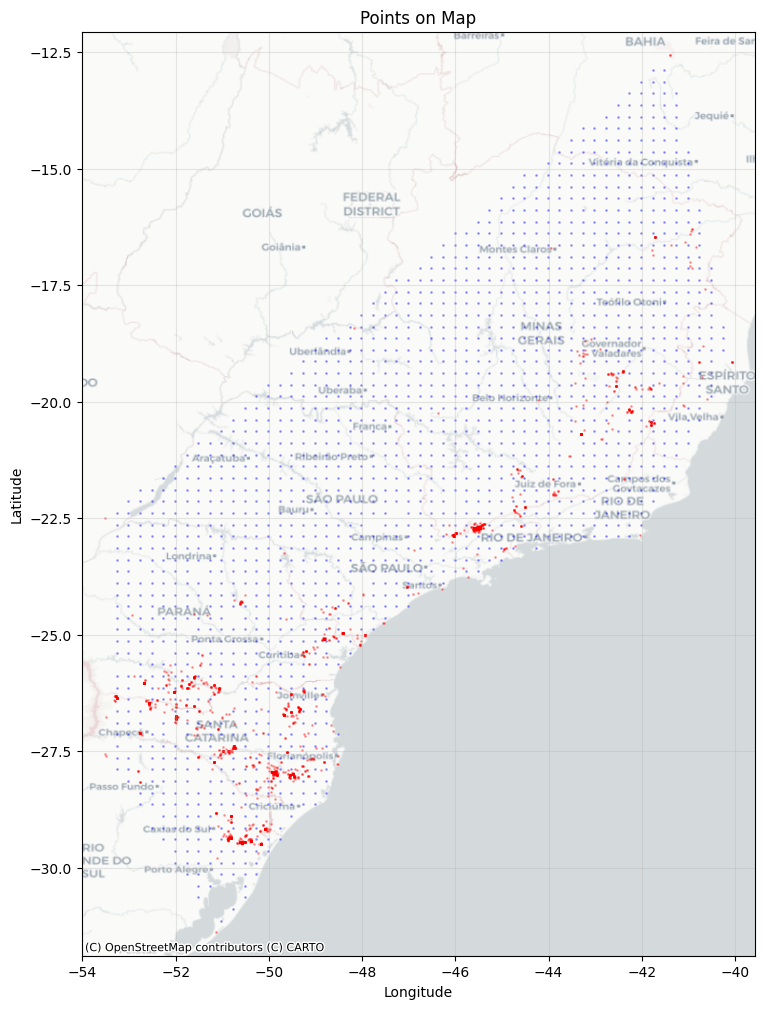

In [4]:
plot_points(df = df)